In [1]:

import os
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import copy
import ipdb

# Pipelines (a.k.a parts of the Neural Network)
from Pipelines.kitti_loader import KITTIDataset
from Pipelines.pillarizer import PillarFeatureNet, Pillarization, PseudoImageDataset
from Pipelines.backbone import BackBone
from Pipelines.detection_head import DetectionHead
from Pipelines.anchors import Box2D, Anchor

from Utils.transformations import transform_to_canvas, transform_to_grid, map_to_img
from Utils.iou import calculate_iou
from Utils.collate import normalize_annotations
from Utils.boxes import create_boxes_tensor # FIXME: Should be in visualization instead

# Visualization tools:
from Visualization.visz_pointcloud_w_label import plot_point_cloud_with_bboxes_o3d
from Visualization.visz_bboxes import visualize_batch_bounding_boxes


# Some Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)
DESIRED_CLASSES = ['Car'] # More classes can be added here
SCALE_FACTOR = 1.5
H = 500
W = 440


ANCHORS = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # Anchors as tensor: (height, width, height, z_center, orientation)
                       [1.6, 3.9, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.6, 0.8, 1.73, -0.6, 1.5708]]
                       )

mapped_anchors = ANCHORS.detach().clone()
mapped_anchors[:,0:2] /= PILLAR_SIZE[0]


# Define a dictionary to map attributes to their indices
attributes_idx = {
    'norm_x': 7,
    'norm_y': 8,
    'norm_z': 9,
    'norm_h': 10,
    'norm_w': 11,
    'norm_l': 12,
}

for anchor_tensor in mapped_anchors: # NOTE: This is regardless of the batch, it is for all the training and testing
    anchor = Anchor(width=anchor_tensor[1], height=anchor_tensor[0])
    anchor.create_anchor_grid(H,W) # Creates grid
    anchor.create_anchors()
    break # FIXME: Get rid of this
    #anchors_list.append(anchor)



print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [2]:
train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'
test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

train_set = KITTIDataset(pointcloud_dir=train_pointclouds_dir, labels_dir=train_labels_dir)

# TODO: Add Loader for test set (No labels)




Visualize a pointcloud with its annotations

In [3]:
# Example usage:
random_idx_sample = random.randint(0,7000)
point_cloud, labels_to_show = train_set[0]  # TODO: Is it necessary to rotate bounding box 90 deg?
geometries = plot_point_cloud_with_bboxes_o3d(point_cloud.numpy(), labels_to_show)

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin


/home/adlink/Documents/ECE-57000/ClassProject/github/PointPillars/Implementation/Pipelines/kitti_loader.py:50: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


Batch data:

In [3]:
# IMPORTANT: Set to CPU for pillarization otherwise, expect GPU memory to overflow
device =  torch.device('cpu')

# Create a collate function to handle variable-sized labels:
def collate_batch(batch):
    point_clouds, annotations = zip(*batch)
    point_clouds = torch.stack(point_clouds, dim=0)
    
    normalized_annotations = normalize_annotations(annotations, pillar_size=PILLAR_SIZE,
        x_lims=(X_MIN, X_MAX), y_lims=(Y_MIN, Y_MAX))
    
    return point_clouds, normalized_annotations


        
# Create the dataset and DataLoader
dataset = PseudoImageDataset(pointcloud_dir=train_pointclouds_dir, device=device, kitti_dataset=train_set, aug_dim=AUG_DIM, max_points_in_pillar=MAX_POINTS_PER_PILLAR,
                             max_pillars=MAX_FILLED_PILLARS, x_min=X_MIN, y_min=Y_MIN, z_min=Z_MIN, x_max = X_MAX, y_max=Y_MAX,
                             z_max = Z_MAX, pillar_size=PILLAR_SIZE)

train_loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_batch) # FIXME: Set batch to 4 again


# Iterate through batches:  
for batch_idx, (pseudo_images, batched_labels) in enumerate(train_loader):
    break # TODO: Erase this and pass the entire dataset

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin


/home/adlink/Documents/ECE-57000/ClassProject/github/PointPillars/Implementation/Pipelines/kitti_loader.py:50: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


Loading point cloud number 0
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/004407.bin
Loading point cloud number 1
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/002395.bin
Loading point cloud number 2
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/005517.bin
Loading point cloud number 3


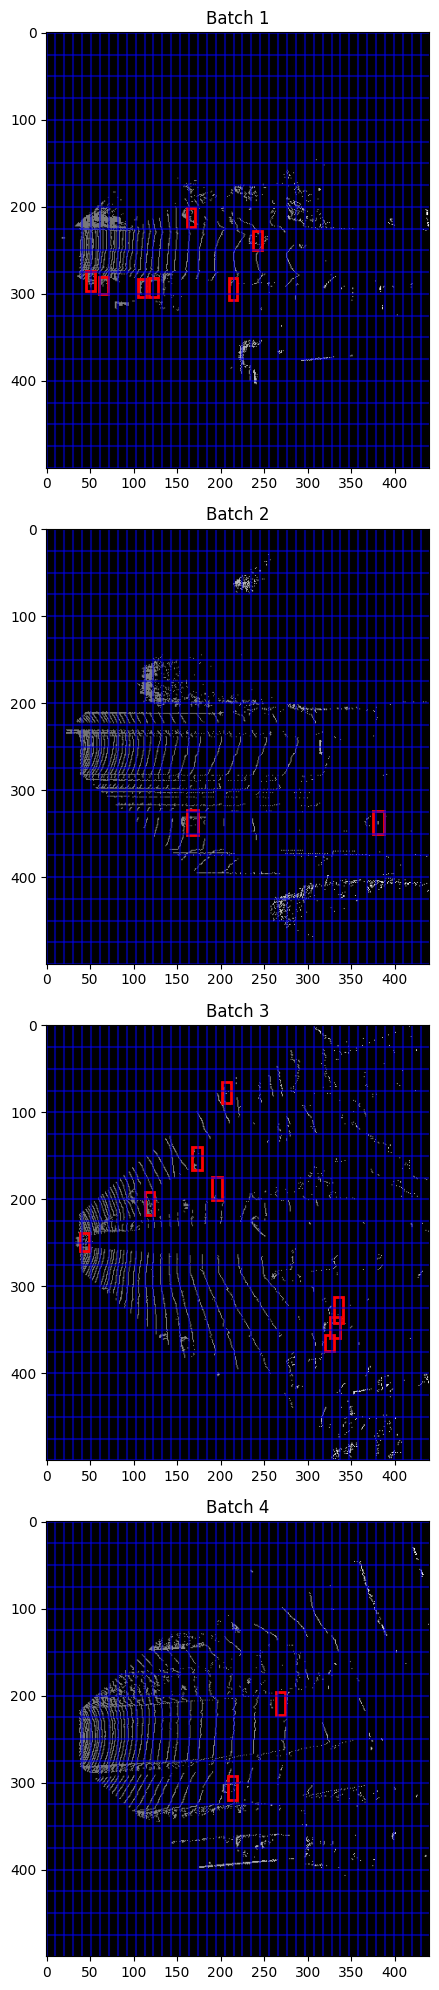

In [19]:


#TODO: Uncomment Me!
#anchors_list = [] 
#roi_boxes_tensor = anchor.generate_ROI_boxes(gt_boxes_tensor=gt_boxes_tensor, 
#            scale_factor=SCALE_FACTOR) # Size (bs, n_obj, (x_min, y_min, x_mx, y_max)) (4, 8,4)

def get_regression_targets(iou_tensor, feature_map_size, threshold=0.5):
    """
    This method finds the best anchor match for each ground truth box based on the IoU tensor.
    It returns the indices on the feature map grid for anchors with the highest IoU above the threshold.
    If no IoU exceeds the threshold, the indices of the anchor with the highest IoU are selected.

    Parameters:
    iou_tensor -- tensor of IoU values, shape (batch_size, n_boxes, num_anchors_x, num_anchors_y)
    feature_map_size -- size of the feature map grid (H, W)
    threshold -- IoU threshold to consider for positive anchor matching

    Returns:
    A dictionary with keys as batch indices and values as lists of (box_index, feature_map_x_index, feature_map_y_index)
    """
    batch_size, n_boxes, num_anchors_x, num_anchors_y = iou_tensor.shape
    feature_map_h, feature_map_w = feature_map_size
    scale_x = feature_map_w / num_anchors_x
    scale_y = feature_map_h / num_anchors_y
    regression_targets = {batch_idx: [] for batch_idx in range(batch_size)}

    # Iterate through each batch and each ground truth box
    for batch_idx in range(batch_size):
        for box_idx in range(n_boxes):
            #if batch_idx == 1:
            #    ipdb.set_trace()
            # Get the IoU for the current box
            box_iou = iou_tensor[batch_idx, box_idx]

            # Find the max IoU and its index
            max_iou = torch.max(box_iou)
            max_idx = torch.argmax(box_iou)
            anchor_x_idx, anchor_y_idx = np.unravel_index(max_idx.item(), (num_anchors_x, num_anchors_y))

            # Scale anchor indices to feature map indices
            feature_map_x_idx = int(anchor_x_idx * scale_x) # FIXME: Fix offsets
            feature_map_y_idx = int(anchor_y_idx * scale_y)

            if max_iou >= threshold:
                # If max IoU is above the threshold, use it as the target
                regression_targets[batch_idx].append((box_idx, feature_map_x_idx, feature_map_y_idx))
            else:
                # If no IoU exceeds the threshold, take the anchor with the highest IoU
                regression_targets[batch_idx].append((box_idx, feature_map_x_idx, feature_map_y_idx))

    return regression_targets


# Ground truth tensor of size (bs, n_boxes, 4)
gt_boxes_tensor = create_boxes_tensor(batched_labels, attributes_idx)

# Get the roi indices:
roi_indices = anchor.get_ROI_indices(gt_boxes_tensor=gt_boxes_tensor, scale_factor=1.5, 
            feature_map_size=(H,W))


# Get IoU tensor and regression targets:
iou_tensor = anchor.calculate_batch_iou(gt_boxes_tensor) 
'''IoU tensor (batch_size, n_boxes, num_anchors_x, num_anchors_y)'''

regression_targets_dict = get_regression_targets(iou_tensor, (H, W), threshold=0.5)
'''A dictionary with keys as batch indices and values as lists of
(box_index, feature_map_x_index, feature_map_y_index'''

classification_targets_dict = anchor.get_classification_targets(iou_tensor=iou_tensor, feature_map_size=(H,W),
                            background_lower_threshold=0.05, background_upper_threshold=0.25)
'''A dictionary with keys as batch indices and values as lists of (box_index, 
feature_map_x_index, feature_map_y_index, class_label)'''


visualize_batch_bounding_boxes(feature_maps=pseudo_images, boxes_tensor=gt_boxes_tensor, 
                               attributes_idx=attributes_idx, visz_anchor=True, anchor=anchor)


In [20]:
regression_targets_dict

{0: [(0, 50, 261),
  (1, 60, 285),
  (2, 110, 285),
  (3, 120, 285),
  (4, 160, 190),
  (5, 240, 238),
  (6, 210, 285),
  (7, 0, 0)],
 1: [(0, 160, 309),
  (1, 370, 309),
  (2, 0, 0),
  (3, 0, 0),
  (4, 0, 0),
  (5, 0, 0),
  (6, 0, 0),
  (7, 0, 0)],
 2: [(0, 40, 238),
  (1, 320, 333),
  (2, 320, 357),
  (3, 330, 309),
  (4, 170, 142),
  (5, 120, 190),
  (6, 190, 166),
  (7, 200, 71)],
 3: [(0, 210, 285),
  (1, 260, 190),
  (2, 430, 71),
  (3, 0, 0),
  (4, 0, 0),
  (5, 0, 0),
  (6, 0, 0),
  (7, 0, 0)]}

In [21]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

Text(0.5, 1.0, 'Features Summed Over Channels')

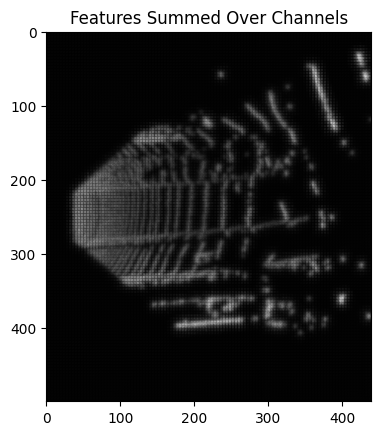

In [22]:
# Forward pass through the backbone:

backbone = BackBone(in_channels=64, out_channels=64, device=device)
backbone_features = backbone(pseudo_images)


# Sum over channels for the original features
backbone_raw = torch.sum(backbone_features[3, :, :, :], dim=0).detach().numpy() # FIXME: Hardcoded batch_size
plt.imshow(backbone_raw, cmap='gray')
plt.title('Features Summed Over Channels')

Now, implement the Detection Head:

In [23]:
#backbone_output = torch.randn(4, backbone_features.size()[1], 252, 252) # Example feature map from backbone
detection_head = DetectionHead(device=device, in_channels=backbone_features.size()[1], grid_size_x=backbone_features.size()[2], 
                        grid_size_y=backbone_features.size()[3], num_anchors=1, num_classes=2) #TODO: Initialize with correct parameters
loc, size, clf, occupancy, angle, heading = detection_head(backbone_features)

In [25]:
# TODO: Now, compute the regression and classification loss between each element of the 
# regression_targets and only classification loss for negative matches.
for n_batch, batch in enumerate(regression_targets_dict):
    for n_target, regresion_target in enumerate(regression_targets_dict[batch]):
        if regresion_target[1] == 0 and regresion_target[2] == 0:
            continue
        else:
            print(f'Regression target: {regresion_target} gt_element {gt_boxes_tensor[n_batch][n_target]}')


Regression target: (0, 50, 261) gt_element tensor([ 45.4688, 274.0000,  56.0312, 297.0000])
Regression target: (1, 60, 285) gt_element tensor([ 60.7812, 280.1562,  70.4688, 300.2188])
Regression target: (2, 110, 285) gt_element tensor([105.5938, 283.4688, 114.7812, 303.6562])
Regression target: (3, 120, 285) gt_element tensor([117.9688, 281.5625, 127.7812, 303.1875])
Regression target: (4, 160, 190) gt_element tensor([161.0625, 200.8750, 170.8125, 222.6250])
Regression target: (5, 240, 238) gt_element tensor([237.7812, 227.8438, 247.2188, 249.4062])
Regression target: (6, 210, 285) gt_element tensor([209.1250, 282.1562, 219.3750, 307.2188])
Regression target: (0, 160, 309) gt_element tensor([161.8438, 322.5000, 174.0312, 351.2500])
Regression target: (1, 370, 309) gt_element tensor([374.5625, 323.4062, 387.3125, 350.4688])
Regression target: (0, 40, 238) gt_element tensor([ 38.7812, 239.0625,  48.9688, 259.8125])
Regression target: (1, 320, 333) gt_element tensor([325.5000, 334.9375, 3

In [12]:

class PointPillarLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(PointPillarLoss, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        # Unpack predictions and targets
        pred_boxes, pred_scores = predictions
        gt_boxes, gt_scores = targets
        
        # Calculate the residuals for the boxes
        da = torch.sqrt((pred_boxes[:, 3] - pred_boxes[:, 0])**2 + (pred_boxes[:, 4] - pred_boxes[:, 1])**2)
        dx = (gt_boxes[:, 0] - pred_boxes[:, 0]) / da
        dy = (gt_boxes[:, 1] - pred_boxes[:, 1]) / da
        dz = (gt_boxes[:, 2] - pred_boxes[:, 2]) / pred_boxes[:, 5]
        dw = torch.log(gt_boxes[:, 3] / pred_boxes[:, 3])
        dl = torch.log(gt_boxes[:, 4] / pred_boxes[:, 4])
        dh = torch.log(gt_boxes[:, 5] / pred_boxes[:, 5])
        dtheta = torch.sin(gt_boxes[:, 6] - pred_boxes[:, 6])
        
        # Stack the residuals
        residuals = torch.stack((dx, dy, dz, dw, dl, dh, dtheta), dim=1)
        
        # Calculate the SmoothL1 loss for localization
        loc_loss = self.smooth_l1_loss(pred_boxes, residuals)
        
        # Calculate the Focal loss for classification
        p = torch.sigmoid(pred_scores)
        pt = p * gt_scores + (1 - p) * (1 - gt_scores)  # p_t
        alpha_t = self.alpha * gt_scores + (1 - self.alpha) * (1 - gt_scores)
        cls_loss = -alpha_t * (1 - pt) ** self.gamma * (gt_scores * torch.log(p) + (1 - gt_scores) * torch.log(1 - p))
        
        # Sum up the localization and classification losses
        total_loss = loc_loss + cls_loss.sum()
        
        return total_loss

# Example usage:
model = ...  # Your model here
criterion = PointPillarLoss()

# Predictions from the model
pred_boxes = ...  # Your predicted boxes here (Nx7)
pred_scores = ...  # Your predicted scores here (Nx1)

# Targets
gt_boxes = ...  # Your ground truth boxes here (Nx7)
gt_scores = ...  # Your ground truth scores here (Nx1)

# Compute the loss
loss = criterion((pred_boxes, pred_scores), (gt_boxes, gt_scores))

{0: [(0, 50, 261),
  (1, 60, 285),
  (2, 110, 285),
  (3, 120, 285),
  (4, 160, 190),
  (5, 240, 238),
  (6, 210, 285),
  (7, 0, 0)],
 1: [(0, 160, 309),
  (1, 370, 309),
  (2, 0, 0),
  (3, 0, 0),
  (4, 0, 0),
  (5, 0, 0),
  (6, 0, 0),
  (7, 0, 0)],
 2: [(0, 40, 238),
  (1, 320, 333),
  (2, 320, 357),
  (3, 330, 309),
  (4, 170, 142),
  (5, 120, 190),
  (6, 190, 166),
  (7, 200, 71)],
 3: [(0, 210, 285),
  (1, 260, 190),
  (2, 430, 71),
  (3, 0, 0),
  (4, 0, 0),
  (5, 0, 0),
  (6, 0, 0),
  (7, 0, 0)]}

Now, create the loss function: